# Hi there!
This notebook will walk you through running your first policy simulation! You should run each cell of code–starting with the imports under this text–working down the notebook sequentially. There will be text boxes like this one instructing you what you need to fill in to get stuff working. 

You're encouraged to experiment, visualize, and add cells as you please. You don't need to understand every line of code you're running, but you can look up functions and pieces of code that do nifty things that you want to be able to reproduce. DM Ayesha or Paco on Slack if you get stuck.

In [1]:
# We're importing a bunch of libraries here that we'll be using below.

import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)

ModuleNotFoundError: No module named 'super_simulation'

# Compartment Architecture
The first step in Spark modeling is always to decide what compartment architecture you want to use. In our case, we're gonna use this one:

**'pretrial' (shell compartment) --> 'prison' (full compartment) --> 'release' (full compartment)**

Make sure you use these three compartment names (pretrial, prison, release) in your data processing!

# Data Pre-processing
We're skipping the early part for now, but you'll still need to go from "clean" data to the data inputs that the Spark model ingests. Feel free to run this cell without thinking about it too much. Essentially, it takes in some raw data and renames some columns, fills in null values, and gets rid of rows and colmuns we don't care about.

In [3]:
raw_va_sentence_df = pd.read_csv(
    '../state/VA/VA_data/unprocessed_va_historical_sentences_v2.csv',
    sep='\t'
)
raw_va_sentence_df['crime_type'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['offense_code'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['crime'] = raw_va_sentence_df['Off1VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['fiscal_year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df = raw_va_sentence_df.rename({'Off1Date':'offense_date'}, axis=1)
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.sentence_type_code != 1]
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.effective_sentence_months != 0]

raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['crime_type'].str.contains('Total')]
raw_va_sentence_df = raw_va_sentence_df.drop(
    ['VCC', 'Offense Group', 'Off1VCC', 'JudgeID', 'ActDisp', 'effsent', 'FiscalYr', 'EffLif'],
    axis=1
)
raw_va_sentence_df.head()

,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,3.0,18.0,2018.0,0.0
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,3.0,10.0,2019.0,0.0
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2017.0,0.0
5,11/17/2018,SPRADLEY,CALEB,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2019.0,0.0
7,12/11/2016,JAMES,ERIC,ASSAULT,ASL1316,ASL1316F6,10KW,3.0,14.0,2017.0,0.0


We can see the first few rows of the dataset above, but let's take a slightly more comprehensive peak at what's in here before we move on! You can run the following cells without changing anything, but feel free to play with them anyway.

In [4]:
# Always a good place to start! .describe() will return a bunch of descriptive statistics about our data.
raw_va_sentence_df.describe([0.05,0.25,0.5,0.75,0.95])

,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
count,52528.000000,52291.000000,52528.000000,51514.000000
mean,2.647102,26.507235,2017.991186,0.001398
std,0.477876,70.993842,0.817416,0.037360
min,2.000000,0.032854,2017.000000,0.000000
5%,2.000000,0.985626,2017.000000,0.000000
25%,2.000000,4.000000,2017.000000,0.000000
50%,3.000000,12.000000,2018.000000,0.000000
75%,3.000000,24.000000,2019.000000,0.000000
95%,3.000000,96.000000,2019.000000,0.000000
max,3.000000,5052.000000,2019.000000,1.000000


In [5]:
# Let's combine first and last name columns into one full name column and check the number of rows of data per person.
raw_va_sentence_df['full_name'] = raw_va_sentence_df.OffFName + ' ' + raw_va_sentence_df.OffLName
sentences_per_person = raw_va_sentence_df.groupby('full_name').count().sort_values('OffLName', ascending=False)

# Run this line  to see the # of rows of data per person in table form.
sentences_per_person

# Uncomment these four lines to see the # of rows of data per person in graph form.
# plt.hist(sentences_per_person.OffLName, bins = 30)
# plt.ylabel('number of people')
# plt.xlabel('number of rows of data per person')
# plt.yscale('log')

,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
full_name,,,,,,,,,,,
MICHAEL SMITH,20,21,21,21,21,21,21,21,21,21,20
MICHAEL BROWN,20,20,20,20,20,20,20,20,20,20,20
JAMES WILLIAMS,18,18,18,18,18,18,18,18,18,18,18
CHRISTOPHER SMITH,17,17,17,17,17,17,17,17,17,17,17
WILLIAM SMITH,15,15,15,15,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...
GERANDO GILBERT,1,1,1,1,1,1,1,1,1,1,1
GERARD ALLEN,1,1,1,1,1,1,1,1,1,1,1
GERARD COOK,1,1,1,1,1,1,1,1,1,1,1


Text(0.5, 0, 'length of sentence in months')

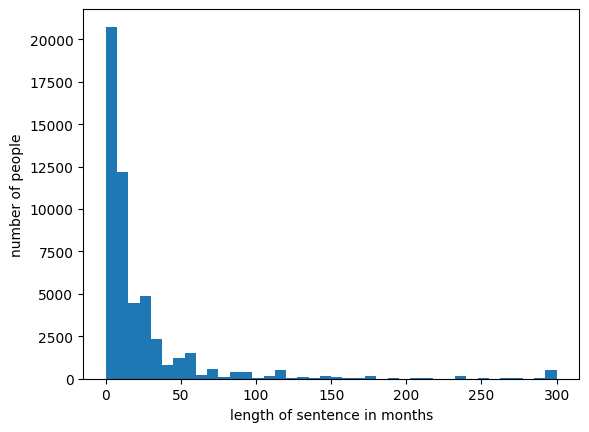

In [6]:
# These lines cap sentence lengths at 25 years, and plot the sentence length distribution in months.
# Why might we want to cap sentence lengths?

temp = raw_va_sentence_df.copy()
temp.loc[temp.effective_sentence_months > 12 * 25, 'effective_sentence_months'] = 12 * 25
plt.hist(temp.effective_sentence_months, bins=40)
plt.ylabel('number of people')
plt.xlabel('length of sentence in months')


## outflows_data
Time to process our data! First up is the outflows_data table. As a reminder, outflows_data counts the number of people transitioning historically into and throughout the system. We're keeping it simple for now, so we'll just try doing outflows for the pretrial compartment. Here is what a final outflows_data table should look like (the actual numbers in the final outflows_table will be different, the table below is just a framework for what a hypothetical table would look like):

In [7]:
pd.DataFrame({
    'compartment': ['pretrial', 'pretrial'],
    'outflow_to': ['prison'] * 2, # this is the same as writing out "prison" two times
    'crime_type': ['NA'] * 2,
    'time_step': [0,1],
    'total_population': [250, 233]
})

,compartment,outflow_to,crime_type,time_step,total_population
0,pretrial,prison,NA,0,250
1,pretrial,prison,NA,1,233


You're up! Turn `raw_va_sentence_df` into an outflows_data table! Some important tips for this:
* Make sure your table has exactly the right columns with the right names when you're done. df.rename() is your friend!
* `time_step` is the number of steps away from the reference date you're at. So with a reference date of 2020.0 and a time_step of 1 year, 2021.0 would be time_step = 1. In our case, the reference_date is 2019.


In [8]:
# Make a copy of the temp table and call it outflows_data.

outflows_data = temp.copy()
outflows_data


,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence,full_name
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,3.0,18.0,2018.0,0.0,KENNETH MOORE
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,3.0,10.0,2019.0,0.0,MATTHEW CLINE
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2017.0,0.0,MARCUS MILLER
5,11/17/2018,SPRADLEY,CALEB,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2019.0,0.0,CALEB SPRADLEY
7,12/11/2016,JAMES,ERIC,ASSAULT,ASL1316,ASL1316F6,10KW,3.0,14.0,2017.0,0.0,ERIC JAMES
...,...,...,...,...,...,...,...,...,...,...,...,...
74313,6/1/2017,CUNNINGHAM,JACOB,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,3.0,8.0,2018.0,0.0,JACOB CUNNINGHAM
74314,6/27/2017,STURDIVANT,JUSTIN,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,3.0,13.0,2018.0,0.0,JUSTIN STURDIVANT
74315,11/30/2017,MAINES,BRADY,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,3.0,7.0,2019.0,0.0,BRADY MAINES
74316,12/26/2016,MORRIS,DAVID,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9TH,2.0,5.0,2018.0,0.0,DAVID MORRIS


In [10]:
# Step 1: Use .groupby() to get one row per crime_type per year in outflows_data, and get the maximum counts 
# of each crime_type. Hint: .count() and .max() are your friend!

# * your code here *
outflows_data = outflows_data.groupby(['crime_type', 'fiscal_year']).count().max(axis=1).reset_index()

# Step 2: Change the data to be per month instead of per year. Your table should get 12 times longer when you do this.
# To do this, fill in the for loop below:

outflows = pd.DataFrame()

for _, row in outflows_data.iterrows():
    for i in range(12):
        outflows = outflows.append({
            'crime_type': row['crime_type'],
            'time_step': (row['fiscal_year'] - 2019) * 12 + i,
            'total_population': row[0] / 12
        }, ignore_index=True)

# for _, row in outflows_data.iterrows():
#     for i in range(12):
#         outflows = outflows.append({
#             'crime_type': # * your code here *,
#             'time_step': # * your code here *,
#             'total_population': # * your code here *
#         }, ignore_index=True)
        
# Step 3: Add in any of the columns you're missing, drop any you don't want, and rename the ones you want to keep.
# The lines below convert the crime_type category from unique crime_types to VIOLENT and NONVIOLENT.

crime_category = {'ASSAULT': 'violent', 'BURGLARY/DWELLING': 'nonviolent', 'BURGLARY/OTHER': 'nonviolent', 
                  'DRUG OTHER': 'nonviolent', 'DRUG/SCHEDULE I/II': 'nonviolent', 'FRAUD': 'nonviolent',
                  'KIDNAPPING': 'violent', 'LARCENY': 'nonviolent', 'MISC/PERSON & PROPERTY': 'nonviolent', 
                  'MISC_OTHER': 'nonviolent', 'MURDER': 'violent', 'OBSCENITY': 'nonviolent',
                  'OTHER SEXUAL ASSAULT': 'violent', 'RAPE': 'violent', 'ROBBERY': 'violent', 
                  'TRAFFIC FELONY': 'nonviolent', 'WEAPONS/FIREARMS': 'nonviolent'}
outflows['crime_type'] = outflows['crime_type'].apply(lambda x: crime_category[x]).str.upper()

# Add in the "compartment" column and the "outflow_to" column. Right now, the only value in "compartment"
# will be "pretrial", and the only value in "outflow_to" will be prison.

# * your code here *
outflows['compartment'] = 'pretrial'
outflows['outflow_to'] = 'prison'

# Step 4: Ensure the columns of our table have the correct types. In particular, make sure the `time_step` column
# has type int and `total_population` column has type float.

# * your code here *
outflows

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_67226/2897155860.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows = outflows.append({
/var/folders

,crime_type,time_step,total_population,compartment,outflow_to
0,VIOLENT,-24.0,0.083333,pretrial,prison
1,VIOLENT,-23.0,0.083333,pretrial,prison
2,VIOLENT,-22.0,0.083333,pretrial,prison
3,VIOLENT,-21.0,0.083333,pretrial,prison
4,VIOLENT,-20.0,0.083333,pretrial,prison
...,...,...,...,...,...
607,NONVIOLENT,7.0,0.083333,pretrial,prison
608,NONVIOLENT,8.0,0.083333,pretrial,prison
609,NONVIOLENT,9.0,0.083333,pretrial,prison
610,NONVIOLENT,10.0,0.083333,pretrial,prison


Fantastic job! That was tricky. Now you have an outflows table.

## transitions_data
Onto the transitions_data table! Transitions_data should have one row of data per full compartment (in this case, every one except pretrial, since pretrial is a shell compartment) that captures the average length of stay (LOS) in that compartment. Here is what a final transitions table should look like:

In [ ]:
pd.DataFrame({
    'compartment': ['prison'] * 2 + ['release'] * 1,
    'outflow_to': ['release'] * 3,
    'crime_type': ['NA'] * 3,
    'compartment_duration': [48,156, 1],
    'total_population': [0.6, 0.4, 1]
})

Okay, you're up! Turn `raw_va_sentence_df` into a transitions_data table!


In [12]:
transitions_attempt = raw_va_sentence_df.copy()

# These lines of code below will drop any NaN values and round up every value in effective_sentence_months 
# to make sure we have no non-integer- or zero-length sentences.
transitions_attempt = transitions_attempt.loc[transitions_attempt.effective_sentence_months.notnull()]
transitions_attempt.loc[:, 'effective_sentence_months'] = transitions_attempt.effective_sentence_months.apply(np.ceil)

# Step 1: Use a groupby operation to get one row per crime_type per sentence length.

# * your code here *

# Step 2: Add in any of the columns you're missing, drop any you don't want, and rename the ones you want to keep.
# Your column names should now match the example exactly. This logic will be similar to the logic used to change the
# columns in the outflows dataframe. As a reminder, you need a "compartment" column, an "outflow_to" column,
# "crime_type column", a "compartment_duration" column, and a "total_population" column.

# * your code here *

# Step 3: You've now finished the transitions data for the prison compartment, but we still need transitions data
# for the release compartment. For our purposes, we're gonna assume no recidivism, which means people can just go
# from release back to release (just like the example above). Create a second transitions_data table for release
# that has one trivial transition from release to itself for each subgroup (VIOLENT and NONVIOLENT).

# * your code here *

# Step 4: Concatenate your two transitions tables together to get one final transitions_data

# * your code here *

# Step 5: Ensure the columns of our table have the correct types. In particular, make sure the `compartment_duration`
# and `total_population` columns both have type float.

# * your code here *


Killin it!! Now let's take a look at what we just made and sanity-check that it looks reasonable:

In [ ]:
transitions_data

## total_population_data
Last but not least: the total_population table. You'll have to go grab data for this one yourself. The data you need is on page 37 of this [report](https://vadoc.virginia.gov/media/1623/vadoc-financial-annual-mis-report-2020.pdf).

We just need the total population for the year 2019, with which we'll make our final data input table. A hypothetical total_population_data table should look like this:

In [ ]:
pd.DataFrame({
    'compartment': ['prison'] * 4,
    'time_step': range(3,7),
    'total_population': [2500, 2800, 3030, 2820]
})

Okee you're up! Turn the table from the DOC report into a `total_population_data` table! Some important tips for this:
* Make sure your table has exactly the right columns with the right names when you're done.
* `time_step` is the number of steps away from the reference date you're at. So with a reference date of 2020.0 and a time_step of 1 year, 2022.0 would be time_step = 2. In our case, the reference_date is 2019.

In [ ]:
# Step 1: Input the data from the DOC report into a pandas DataFrame. Feel free to start with the example table
# above if that's easier. 

#* your code here *

# Step 2: Ensure the columns of our table have the correct types. In particular, make sure the `time_step` column has
# type int and `total_population` column has type float. You can use df.col_name = df.col_name.astype(type)

#* your code here *

## Uploading our data
The final step in pre-processing is to upload our data to Google BigQuery. If this next cell gives you a permission error, you need to go set up your Google Cloud access–follow these steps:
1. Work through just the installation section of [this page](https://cloud.google.com/sdk/docs/quickstart). Make sure you log in with your Stanford email.
2. Open a terminal window and navigate to your Github repository folder. Run the following commands:
3. `gcloud auth application-default login` --> This will prompt you to log in to your google cloud account
4. `gcloud config set project recidiviz-staging`

Once you're set up, you can try the upload again.


In [ ]:
# STEP 1: pick a `simulation_tag` for your simulation. "ayesha_parole_test" would be a reasonable example...
# Make sure you go to the yaml configuration and change the simulation tag there. Here's the path for finding the 
# yaml configuration:'../../state/VA/2022/test_configurations/walkthru_user_inputs.yaml')

simulation_tag = ""


upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/test_configurations/walkthru_user_inputs.yaml',
)

# Running a baseline
We're ready to build a simulation now! First step is initializing a simulation object, called a SuperSimulation. When we initialize it we pass in the filepath of our YAML configuration, so before you continue you need to go to that file, located in `recidiviz-data/recidiviz/calculator/modeling/population_projection/state/VA/2022/test_configurations`, and change the simulation_tag to match the one you chose above.

In [ ]:
# Don't worry about any warnings. As long as this doesn't fail, you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/VA/2022/test_configurations/walkthru_user_inputs.yaml'
)

Now we're going to run a baseline simulation. This is an oppportunity to make sure the data we generated is valid, and to sanity-check the basic dynamics it generates. You should just be able to run the code below, but if you feel like it you can also include `release` in the `display_compartments` list to see that population evolve too.
*Make sure you pause to think about the graph this generates*. Do you believe this is actually close to reality? Is there something off, and if so what might be causing it?

In [ ]:
#This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments)

# Running a policy scenario
I've filled out a lot of the code for you here, but once you finish out the missing pieces, definitely play around with the stuff I did for you. The whole appeal of the Spark model is how easy it is to test out different policy scenarios once you get the baseline running.

Without worrying about all the details, the main thing to understand here is that a policy function transforms the transitions data of a given compartment. By applying one or multiple per compartment that is affected in the policy scenario, we can simulate the effects of the reform in question. `policy_list` is thus just a list of policy functions that gets passed into the simulation so it knows what to change in the policy scenario.

Some important pointers:
* A SparkPolicy specifies both compartment and subgroup. If you want a policy to apply to every subgroup you need one SparkPolicy per subgroup!
* Retroactivity determines whether or not a policy applies to people who are already incarcerated. Try toggling it on and off and see what happens!
* Order matters! If policy A shortens sentences by 50% and policy B shortens them by 1 year, the policy_list [A,B] will be different from the policy_list [B,A]

In [ ]:
# To start, let's model enabling parole by shortening the fraction of their sentence that people must serve.
# Currently, they cannot serve less than 85%. Let's suppose that this policy will bring that number down to 60%,
# and do so for everyone in prison. Think about how you should shorten prison transitions to capture that change, 
# then pick the appropriate parameters below!

REDUCTION_TYPE = ?? # This should either be '*' or '+'. If you make it '+', it will change compartment_duration L to
                    # L - LOS_REDUCTION. If you make it '*', it will change L to L * (1 - LOS_REDUCTION)
LOS_REDUCTION = ?? # This parameter determines how much shorter compartment duration gets for affected individuals.
AFFECTED_FRACTION = ?? # This parameter determines the fraction of the compartment population affected by the change.
RETROACTIVE = ?? # This should either be True or False

#### Do not change things below this line for this cell! ####

def apply_reinstated_parole():
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [OUTFLOW],
                       'reduction_size': [LOS_REDUCTION], 
                       'affected_fraction': [AFFECTED_FRACTION]
                   }),
                   reduction_type=REDUCTION_TYPE,
                   retroactive=RETROACTIVE)

policy_list = [SparkPolicy(policy_fn=apply_reinstated_parole(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'NA'},
                                           policy_ts=24,
                                           apply_retroactive=RETROACTIVE)]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

How do those results look? Does this match your expectation for the magnitude of this policy's impact?

In [ ]:
# Now let's try mixing it up a bit. Now we want you to try changing the policy so it only applies to 
# non-violent offenders. Suppose 60% of people in prison are non-violent.

LOS_REDUCTION = ??
AFFECTED_FRACTION = ??
REDUCTION_TYPE = ??
RETROACTIVE = ??

# If you're unsure what a variable will do, try running it with different values and see how the results change

def apply_reinstated_parole():
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [OUTFLOW],
                       'reduction_size': [LOS_REDUCTION], 
                       'affected_fraction': [AFFECTED_FRACTION]
                   }),
                   reduction_type=REDUCTION_TYPE,
                   retroactive=RETROACTIVE)

policy_list = [SparkPolicy(policy_fn=apply_reinstated_parole(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'NA'},
                                           policy_ts=24,
                                           apply_retroactive=RETROACTIVE)]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

How do these results compare to your previous scenario? Is it more or less? By how much? Can you think of a way to validate that that result is reasonable?

# Extensions
Try these to get a feel for how each of the things you worked on affects the final result:

### Outflows data
What happens to the simulation when you change the magnitude of outflows data? What about if you added another year (or years) of data?

### Transitions data
What happens to the simulation if you change the `compartment_duration` of the transitions data? What about if you add another row of data (e.g. everything else the same but change the `compartment_duration` for the second one)? What happens if you make release feed to prison instead of itself? Why?

### Total population data
What happens to the simulation if you change the magnitude of the population data? Does it change the beginning and the end of the simulation differently? What happens if you pass an empty table (i.e. `total_population_data = pd.DataFrame()`)?